# Fasat Charlie multi-spectral (fasat_charlie_ms) Glaciar Gray

Modificacion de Notebook de https://github.com/Data-Observatory/DataCubeTraining/blob/main/material_complementario/02b_Limpieza_fasat_charlie_ms.ipynb

Utilizaremos el notebook `02_Limpieza.ipynb` y `03_Análisis_básico.ipynb` como base para el proceso a desarrollar. 

Exploraremos las imágenes disponibles y su extensión.

## 0. Cargar librerías y datos

In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [2]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [3]:
dc = datacube.Datacube(app='fc-gray') 

In [4]:
query = {
    "product": "fasat_charlie_ms",
    #"y": (-34.00, -32.00), 
    #"x": (-71.85, -70.00),
    #"time": ("1990-01-01", "2024-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-5.8, 5.8),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

***

# 2. Explorar imágenes Fasat Charlie

Durante esta sección exploraremos las imágenes enfocados en el sector de Petorca, Valparaíso y Glaciar Grey.
Para esto nos apoyaremos en un archivo vectorial de extensión geopackage llamado "dataton_zonas.gpkg"

In [5]:
import geopandas as gpd
poly = gpd.read_file("dataton_zonas.gpkg")
poly

zona                                           geometry
0           petorca  MULTIPOLYGON (((-71.01176 -32.12425, -71.05574...
1        valparaíso  MULTIPOLYGON (((-71.38728 -32.81148, -71.55132...
2  torres del paine  MULTIPOLYGON (((-72.92871 -51.27458, -72.80814...

## 3. Glaciar Grey

Utilizando el tercer polígono del vector `dataton_zonas` hacemos el proceso que en la zona anterior.

In [6]:
xmin, ymin, xmax, ymax = poly.iloc[[2]].total_bounds

print("xmin: ", xmin) # longitud
print("ymin: ", ymin) # latitud
print("xmax: ", xmax) # longitud
print("ymax: ", ymax) # latitud

ds3 = dc.load(x = (xmin, xmax), y = (ymin, ymax), **query)
ds3

xmin:  -73.35676489704194
ymin:  -51.274579580124886
xmax:  -72.80813635761145
ymax:  -50.839518983207824


<xarray.Dataset>
Dimensions:      (time: 9, y: 8706, x: 7089)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-19T14:34:29.659347 ... 2018-05...
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.311e+06 4.311e+06
  * x            (x) float64 1.933e+05 1.933e+05 ... 2.344e+05 2.344e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [7]:
#ds3where: Filter elements from this object according to a condition. Returns elements from 'DataArray', where 'cond' is True, otherwise fill in 'other'.

ds3 = ds3.where(ds3 != 0, np.nan) # cambiar ceros por nan, para que no afecte las estadisticas
ds3.update(ds3 * 0.0001) # reescalar valores digitales a reflectancia. Se utiliza el método de corrección ND*0.0001, donde ND es el valor que posee cada pixel en cada banda
ds3.update(ds3.where((ds3 >= 0) & (ds3 <= 1))) # mantener solo los valores que sean válidos. Debido a que la reflectancia debiese entregar valores entre 0 y 1

<xarray.Dataset>
Dimensions:      (time: 9, y: 8706, x: 7089)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-19T14:34:29.659347 ... 2018-05...
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.311e+06 4.311e+06
  * x            (x) float64 1.933e+05 1.933e+05 ... 2.344e+05 2.344e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Preguntar, corroborar que sean las 22, porque son 9 para gray, considerando multiespectro. 

Si son 9 imagenes temporales. Y tenemos 4 bandas por imagen, entonces son 45?



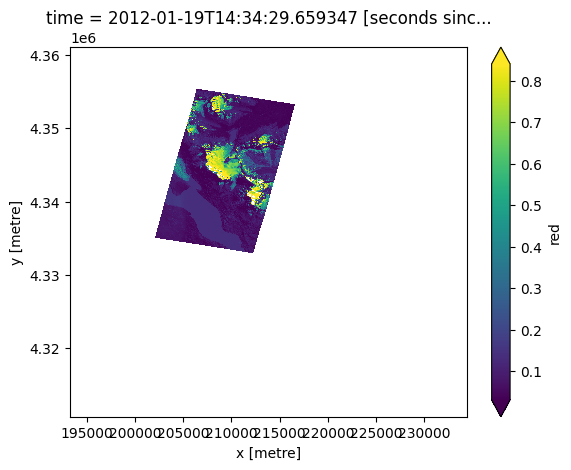

In [8]:
ds3.red.isel(time = 0).plot(robust = True)

### Save arrays (RGBA v1) (version 1)

El objetivo es obtener un cubo numpy RGBA.

In [9]:
# esto ya no se utiliza
#from datacube.utils.cog import write_cog
#write_cog(geo_im = RGB_array, fname = f'RGB_time_{i}_v1.tif', overwrite=True).compute()

In [10]:
from xarray.plot.utils import _rescale_imshow_rgb # usado para reemplazar xarray.plot.imshow(robust = True)

In [11]:
i = 0
R_array = ds3['red'].isel(time=i).to_numpy()
G_array = ds3['green'].isel(time=i).to_numpy()
B_array = ds3['blue'].isel(time=i).to_numpy()
NIR_array = ds3['nir'].isel(time=i).to_numpy()

In [12]:
# test shape mask
print(R_array.shape)
print(np.isnan(R_array).shape)
print((np.isnan(R_array) | np.isnan(G_array) | np.isnan(B_array)).shape) 

(8706, 7089)
(8706, 7089)
(8706, 7089)


In [13]:
# test mask
np.isnan(R_array) | np.isnan(G_array) | np.isnan(B_array)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [14]:
# test mask
1*~(np.isnan(R_array) | np.isnan(G_array) | np.isnan(B_array))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
A_array = 1*~(np.isnan(R_array) | np.isnan(G_array) | np.isnan(B_array)) # calcular transparencia. 0 transparente, 1 opaco

RGBA_cube = np.cbrt(0.6*np.dstack((R_array,G_array, B_array))) # without transparency
#RGBA_cube = np.dstack((R_array,G_array, B_array)) # without transparency

ROBUST_PERCENTILE = 2.0
vmin = np.nanpercentile(RGBA_cube, ROBUST_PERCENTILE)
vmax = np.nanpercentile(RGBA_cube, 100 - ROBUST_PERCENTILE)

#vmin = np.nanmin(RGB_cube)
#vmax = np.nanmax(RGB_cube)

#print(vmin)
#print(vmax)

#https://github.com/pydata/xarray/blob/main/xarray/plot/dataarray_plot.py#L1399-L1645

#RGBA_cube = _rescale_imshow_rgb(RGBA_cube, vmin, vmax, True)
RGBA_cube = _rescale_imshow_rgb(RGBA_cube, None, None, True)

RGBA_cube = np.dstack((RGBA_cube, A_array)) # add transparency

print(RGBA_cube.shape)

(8706, 7089, 4)


### Graficamos el resultado

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


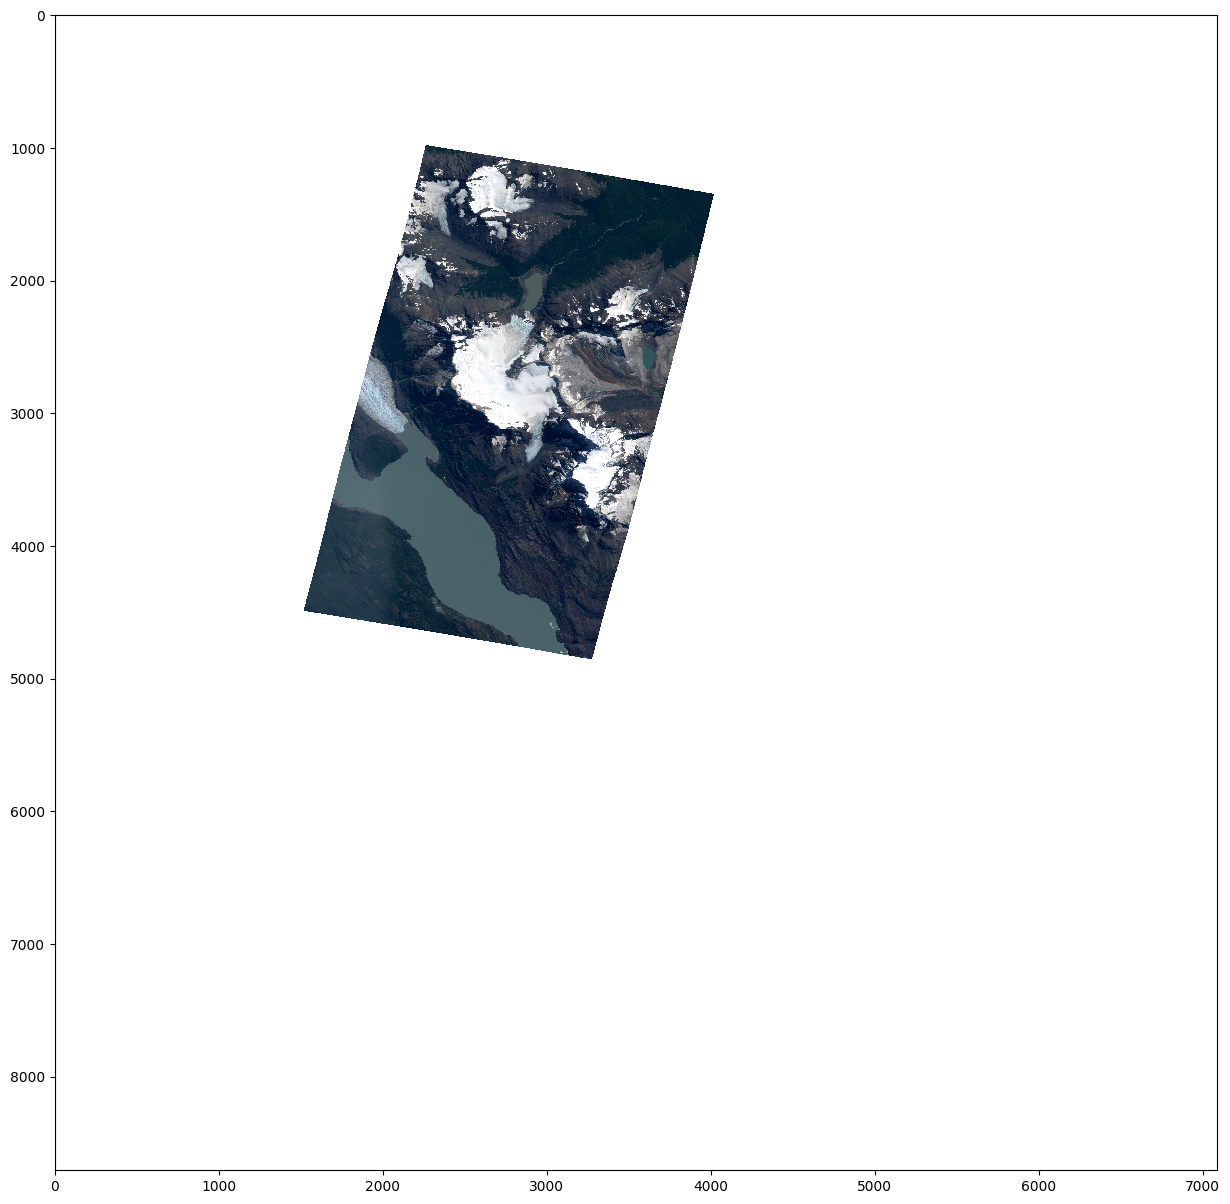

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(RGBA_cube, aspect = 'auto', interpolation = 'nearest')
plt.show()


### Comparación resultado original de DataCube

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


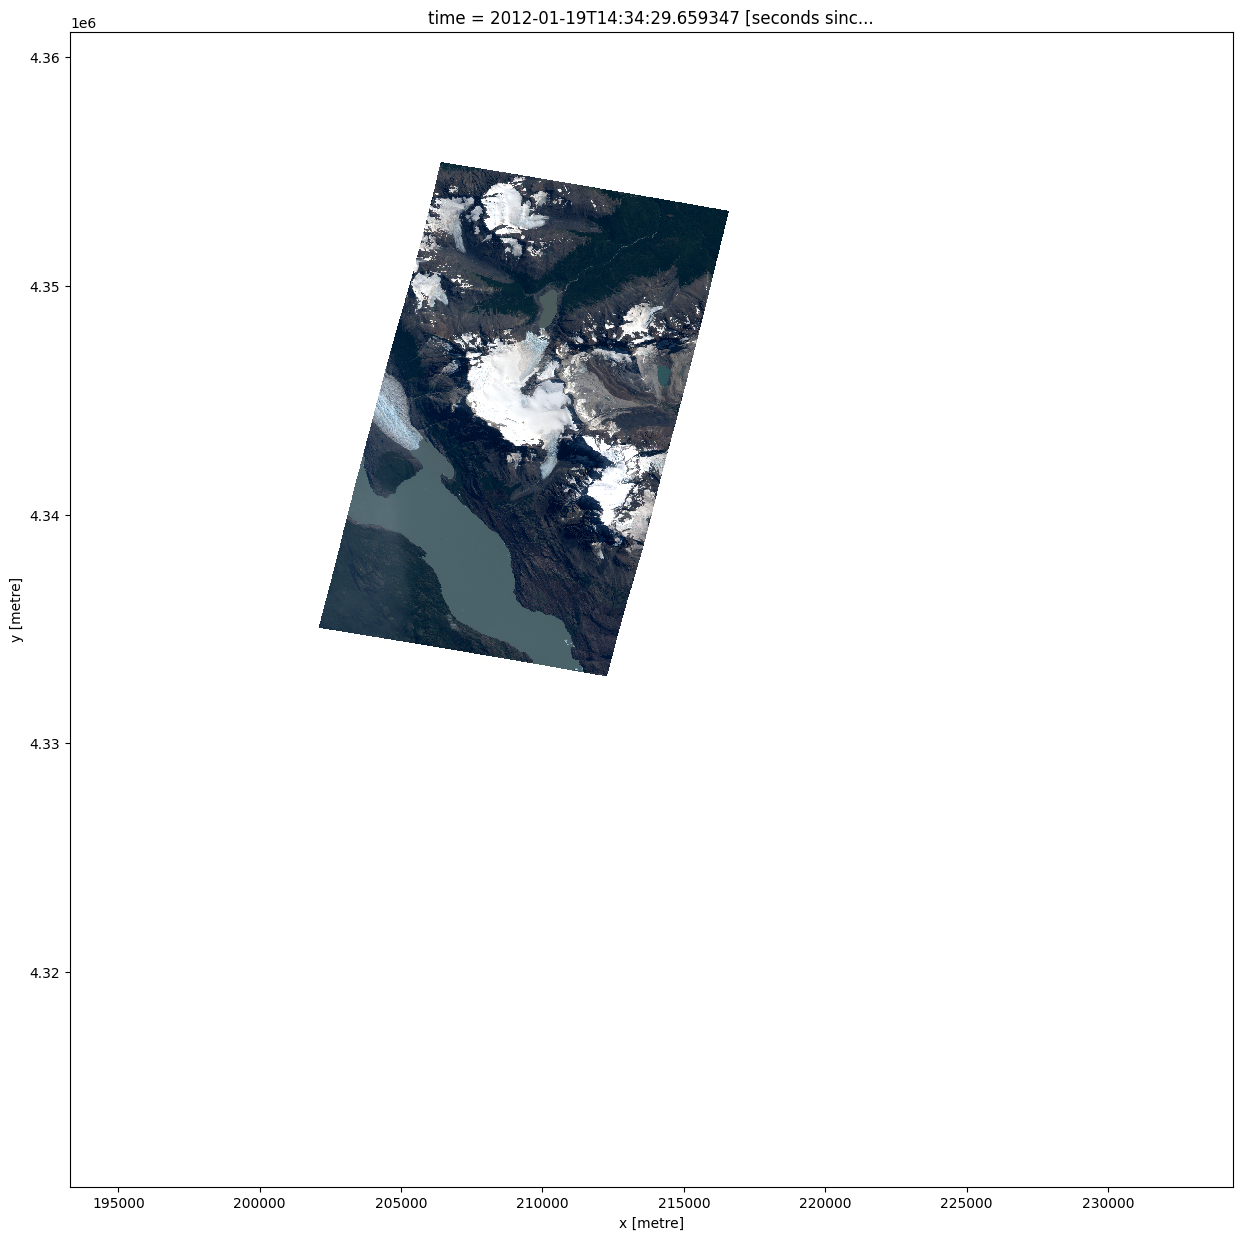

In [17]:
np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = i)).to_array().plot.imshow(robust = True, figsize = (15,15), aspect = 1)

## Mascaras para Fasat-Charlie

Nota: sola las imagenes 0,1 y 6 tienen glaciar


Nota: por defecto no hay mascara para fasat-charlie, por lo que se decide utilizar la metrica NDSI o ANDSI modficado



In [9]:
# https://www.tandfonline.com/doi/full/10.1080/15481603.2023.2257978
# ANDSI modficado, donde SWIR se cambia por red

def create_mask_fasat_c_2(selected_time, min_value, max_value, crop_value):
    ANDSI = ( (ds3['nir']/ds3['red'])-((ds3['green'] - ds3['nir']) / (ds3['green'] +ds3['nir'])) ) / ( (ds3['nir']/ds3['red'])+((ds3['green'] - ds3['nir']) / (ds3['green'] +ds3['nir'])) )
    #ndsi = (ds3['green'] - ds3['nir']) / (ds3['green'] +ds3['nir']) 
    
    
    
    ANDSI.attrs = ds3['green'].attrs  # para mantener atributos geoespaciales


    SELECTED = ANDSI.isel(time = selected_time).compute()
    SELECTED.plot( figsize = (10,10))
    GLACIER = SELECTED.where(SELECTED > min_value).where(SELECTED < max_value ).compute().to_numpy()

    GLACIER[GLACIER > 0.0] = 1

    GLACIER[crop_value:, :] = np.nan # manual crop

    fecha = np.datetime_as_string(ANDSI.isel(time = 6).time.values)
    print(fecha)
    fig, ax = plt.subplots(figsize = (10,10))
    plt.title(fecha)
    ax.imshow(GLACIER, aspect = 'auto')
    plt.show()

    np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = selected_time)).to_array().plot.imshow(robust = True, figsize = (10,10), aspect = 1)

In [10]:
def create_mask_fasat_c(selected_time, min_value, max_value, crop_value):
    ndsi = (ds3['green'] - ds3['nir']) / (ds3['green'] +ds3['nir'])
    ndsi.attrs = ds3['green'].attrs  # para mantener atributos geoespaciales


    SELECTED = ndsi.isel(time = selected_time).compute()
    SELECTED.plot( figsize = (10,10))
    GLACIER = SELECTED.where(SELECTED > min_value).where(SELECTED < max_value ).compute().to_numpy()

    GLACIER[GLACIER > 0.0] = 1

    GLACIER[crop_value:, :] = np.nan # manual crop

    fecha = np.datetime_as_string(ndsi.isel(time = 6).time.values)
    print(fecha)
    fig, ax = plt.subplots(figsize = (10,10))
    plt.title(fecha)
    ax.imshow(GLACIER, aspect = 'auto')
    plt.show()

    np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = selected_time)).to_array().plot.imshow(robust = True, figsize = (10,10), aspect = 1)

### Time 0

2017-11-29T14:49:11.485676000


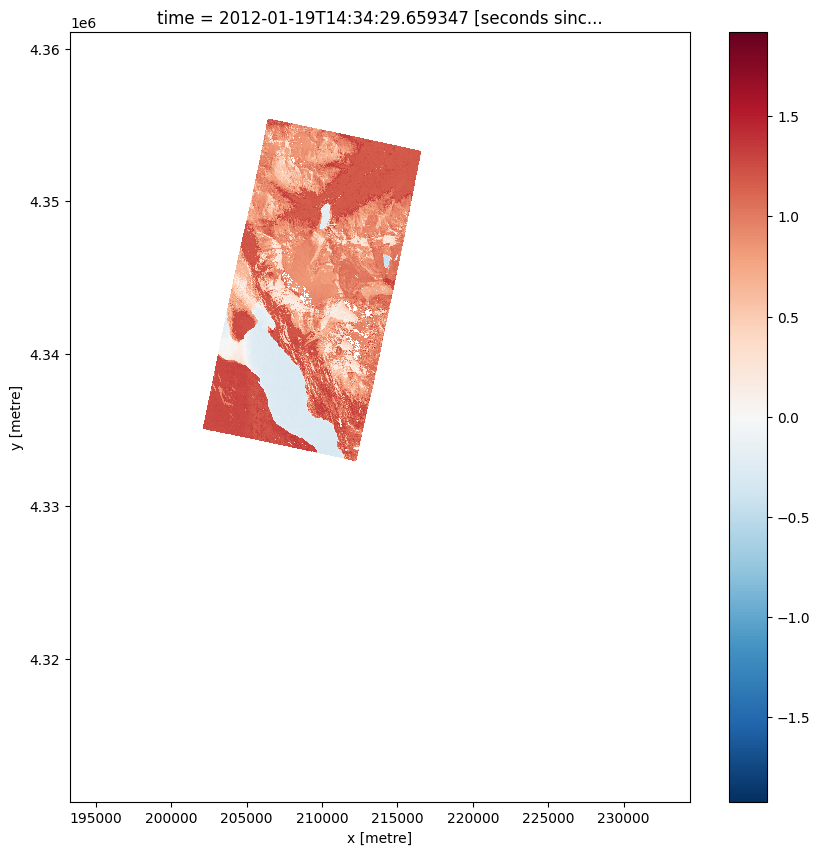

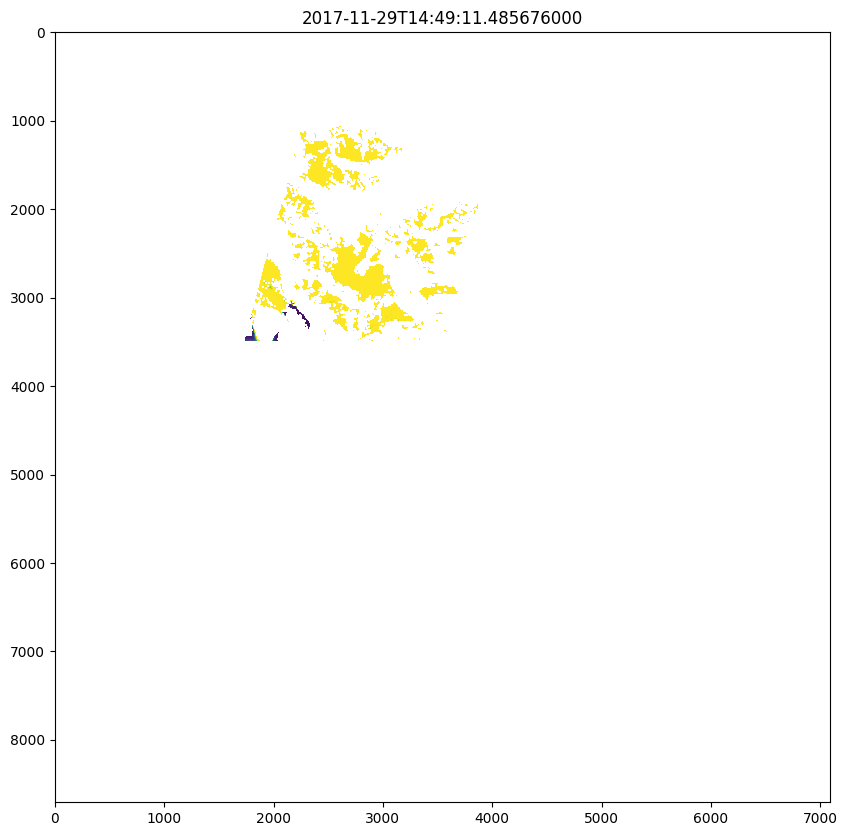

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


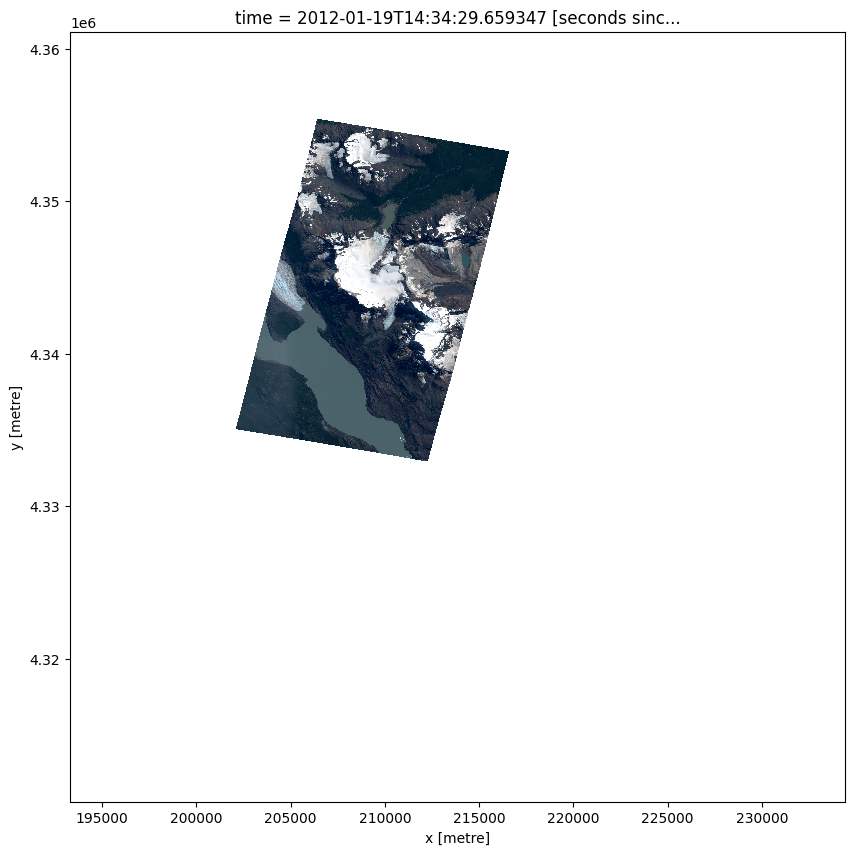

In [11]:
#create_mask_fasat_c(selected_time = 0, min_value = 0.0, max_value = 0.55, crop_value = 3300)
create_mask_fasat_c_2(selected_time = 0, min_value = -0.2, max_value = 1, crop_value = 3500)

### Time 1

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


2017-11-29T14:49:11.485676000


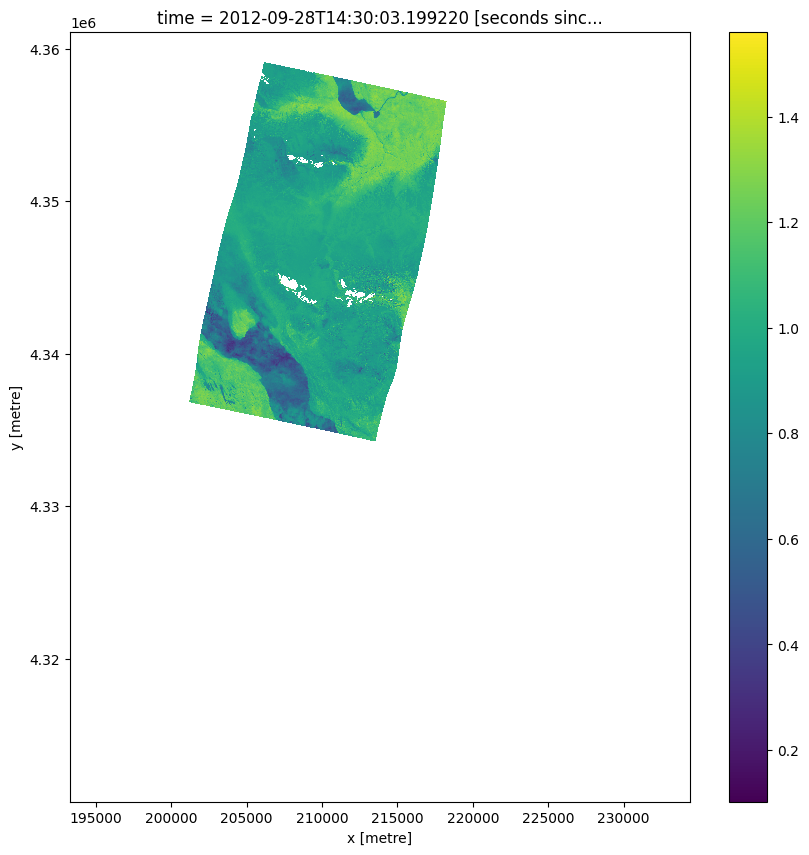

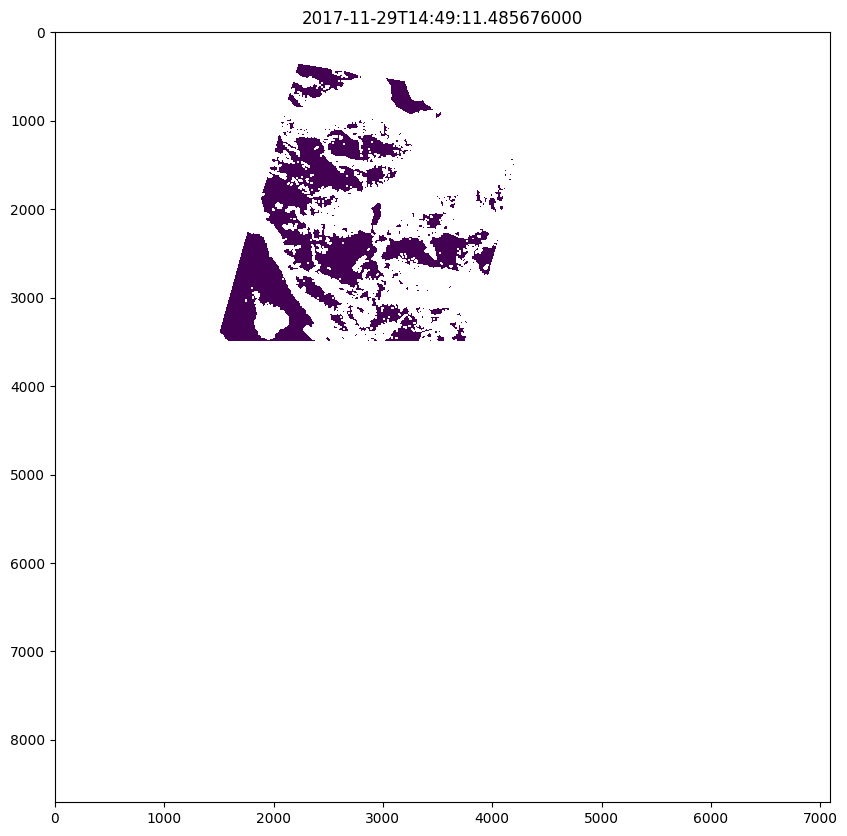

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


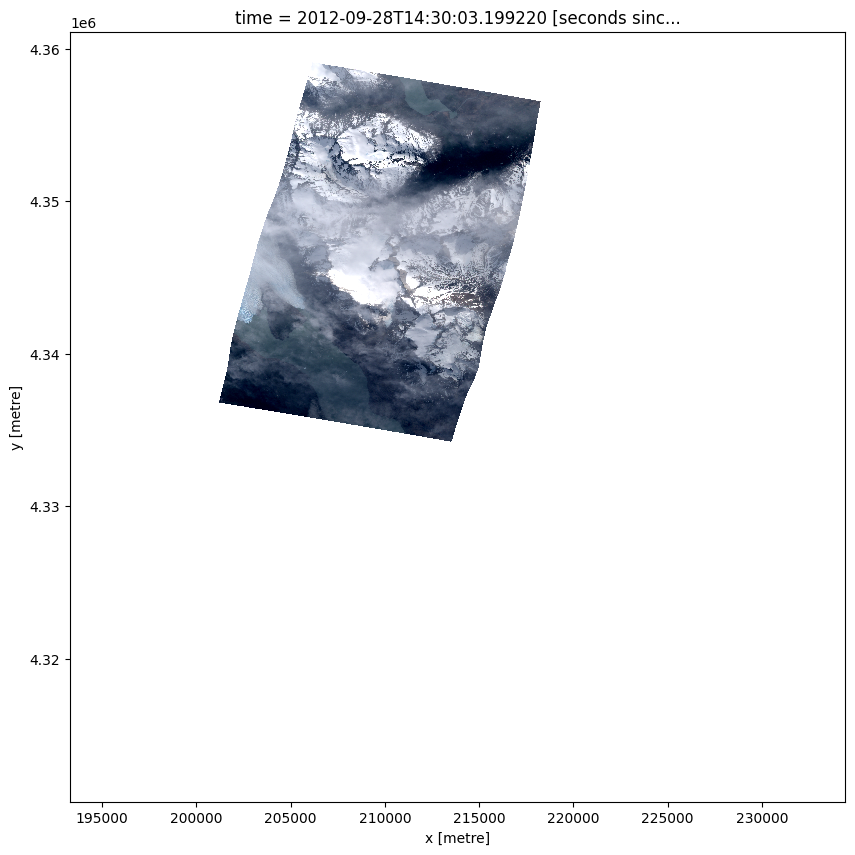

In [12]:
create_mask_fasat_c(selected_time = 1, min_value = 0.0, max_value = 0.18, crop_value = 3500)
#create_mask_fasat_c_2(selected_time = 1, min_value = -0.2, max_value = 1, crop_value = 3500)

### Time 6

2017-11-29T14:49:11.485676000


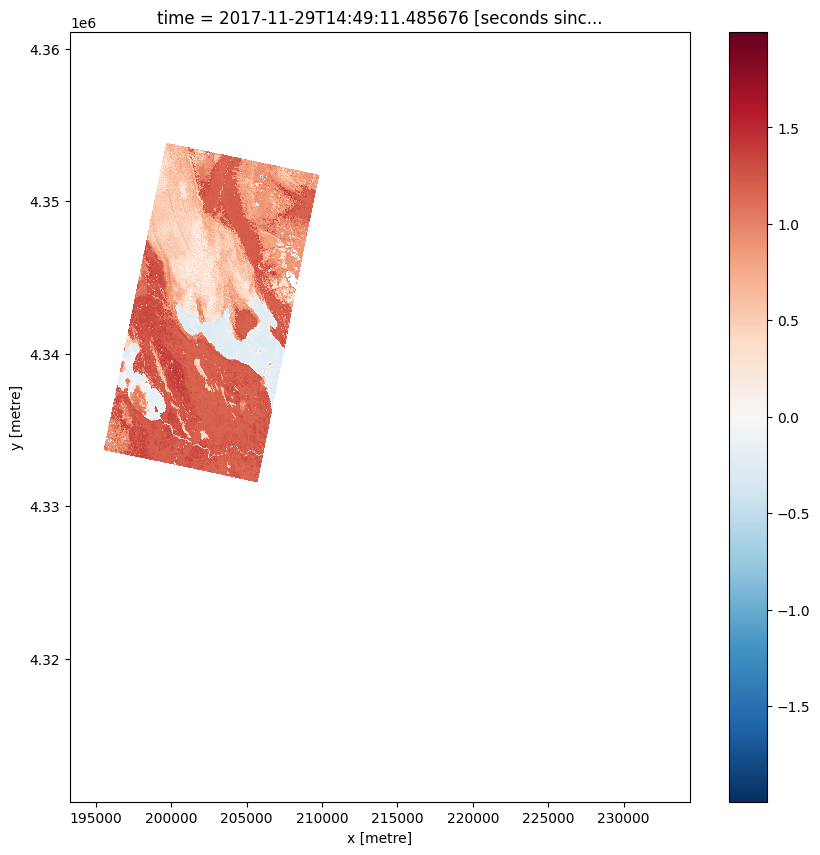

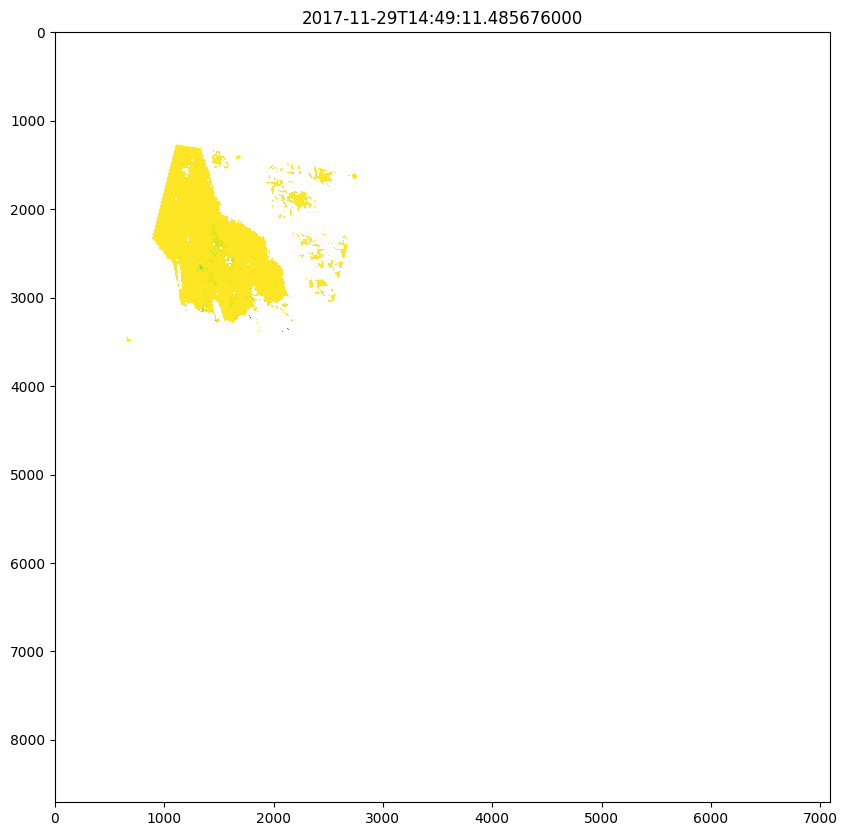

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


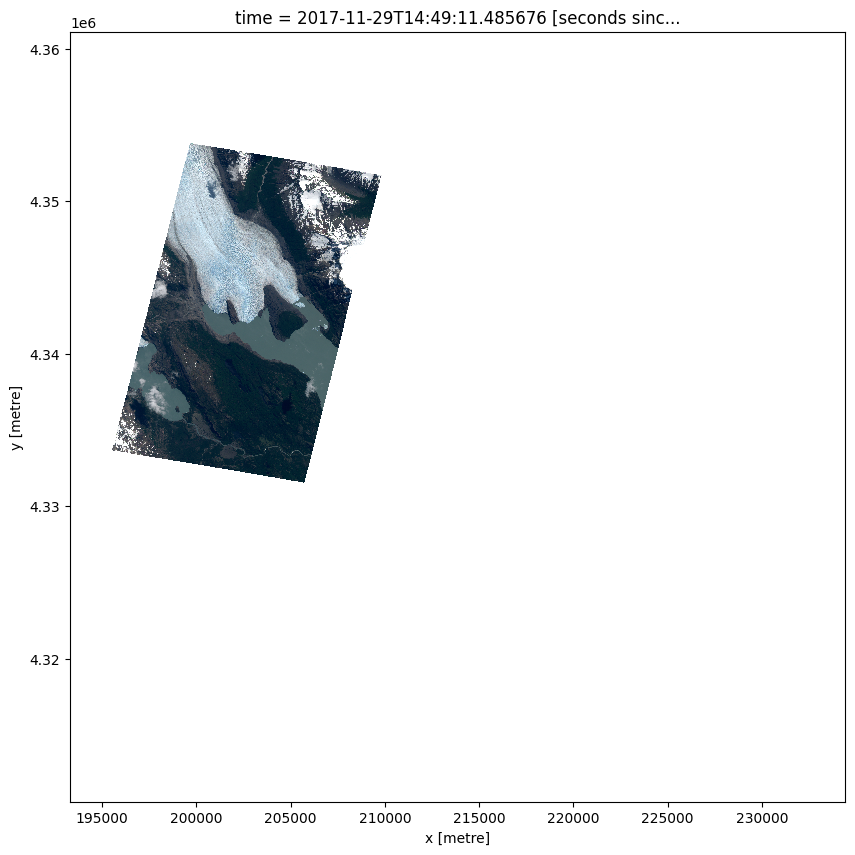

In [11]:
#create_mask_fasat_c(selected_time = 6, min_value = 0.00, max_value = 0.57, crop_value = 3500)
create_mask_fasat_c_2(selected_time = 6, min_value = -0.2, max_value = 1, crop_value = 3500)

## Aplicamos para todas las imagenes

In [ ]:
np.datetime_as_string(ds3['time'].isel(time=i).values)

In [ ]:
for i in range(8):
    print("i: ", i)
    fecha = np.datetime_as_string(ds3['time'].isel(time=i).values)
    print("date: ", fecha)
    
    R_array = ds3['red'].isel(time=i).to_numpy()
    G_array = ds3['green'].isel(time=i).to_numpy()
    B_array = ds3['blue'].isel(time=i).to_numpy()
    
    A_array = 1*~(np.isnan(R_array) | np.isnan(G_array) | np.isnan(B_array)) # calcular transparencia. 0 transparente, 1 opaco

    RGBA_cube = np.cbrt(0.6*np.dstack((R_array,G_array, B_array))) # without transparency

    #ROBUST_PERCENTILE = 2.0
    #vmin = np.nanpercentile(RGBA_cube, ROBUST_PERCENTILE)
    #vmax = np.nanpercentile(RGBA_cube, 100 - ROBUST_PERCENTILE)
    #vmin = np.nanmin(RGB_cube)
    #vmax = np.nanmax(RGB_cube)
    #print(vmin)
    #print(vmax)

    #https://github.com/pydata/xarray/blob/main/xarray/plot/dataarray_plot.py#L1399-L1645
    #RGBA_cube = _rescale_imshow_rgb(RGBA_cube, vmin, vmax, True)
    
    RGBA_cube = _rescale_imshow_rgb(RGBA_cube, None, None, True)

    RGBA_cube = np.dstack((RGBA_cube, A_array)) # add transparency

    print(RGBA_cube.shape)
    
    np.save(f'RGBA/RGBA_{i}_{fecha}_v1.npy', RGBA_cube)
  
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(RGBA_cube, aspect = 'auto', interpolation = 'nearest')
    plt.show()

-----

## Plot All

In [34]:
np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = 0)).to_array()

<xarray.DataArray (variable: 3, y: 8706, x: 7089)>
dask.array<stack, shape=(3, 8706, 7089), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2012-01-19T14:34:29.659347
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.311e+06 4.311e+06
  * x            (x) float64 1.933e+05 1.933e+05 ... 2.344e+05 2.344e+05
    spatial_ref  int32 32719
  * variable     (variable) object 'red' 'green' 'blue'
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


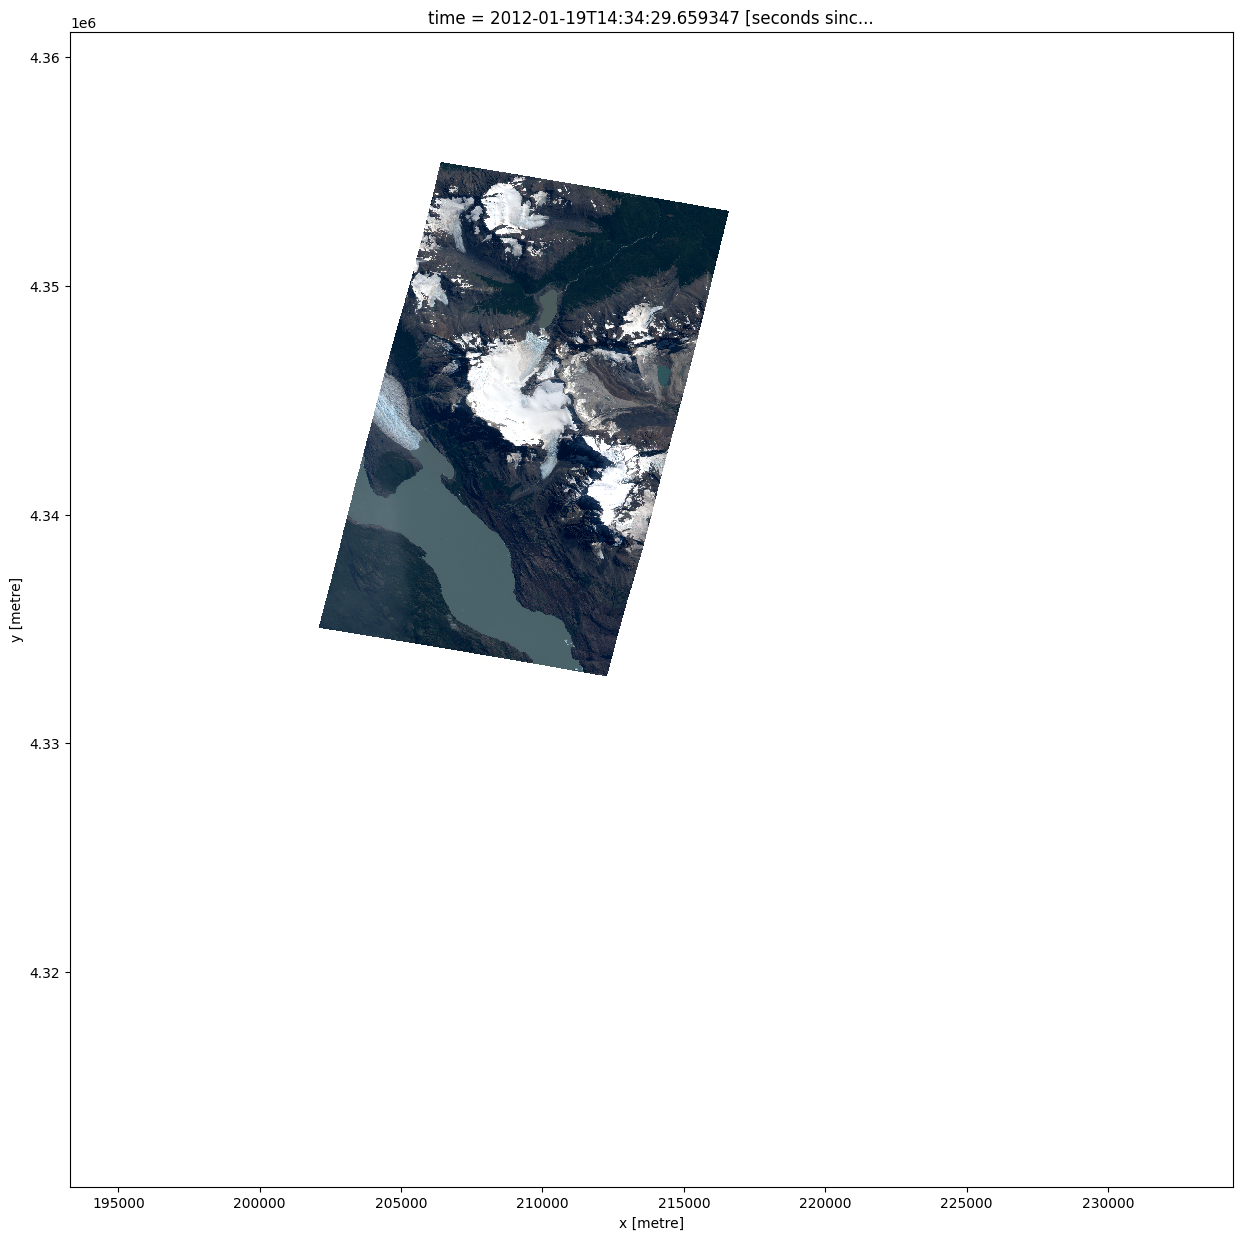

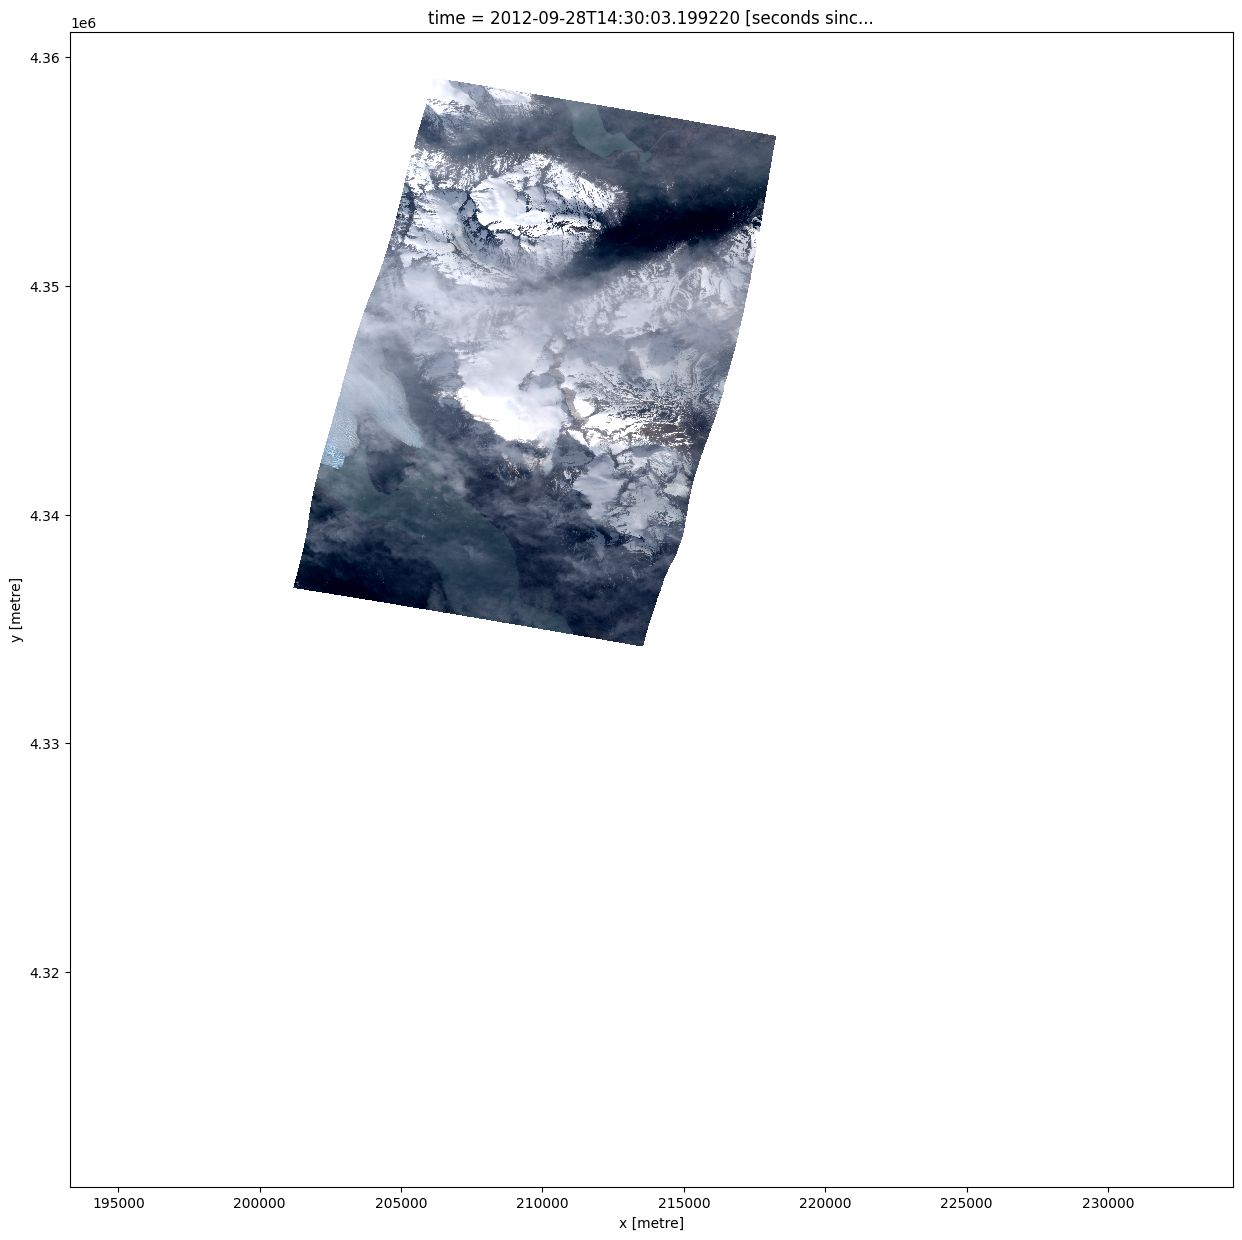

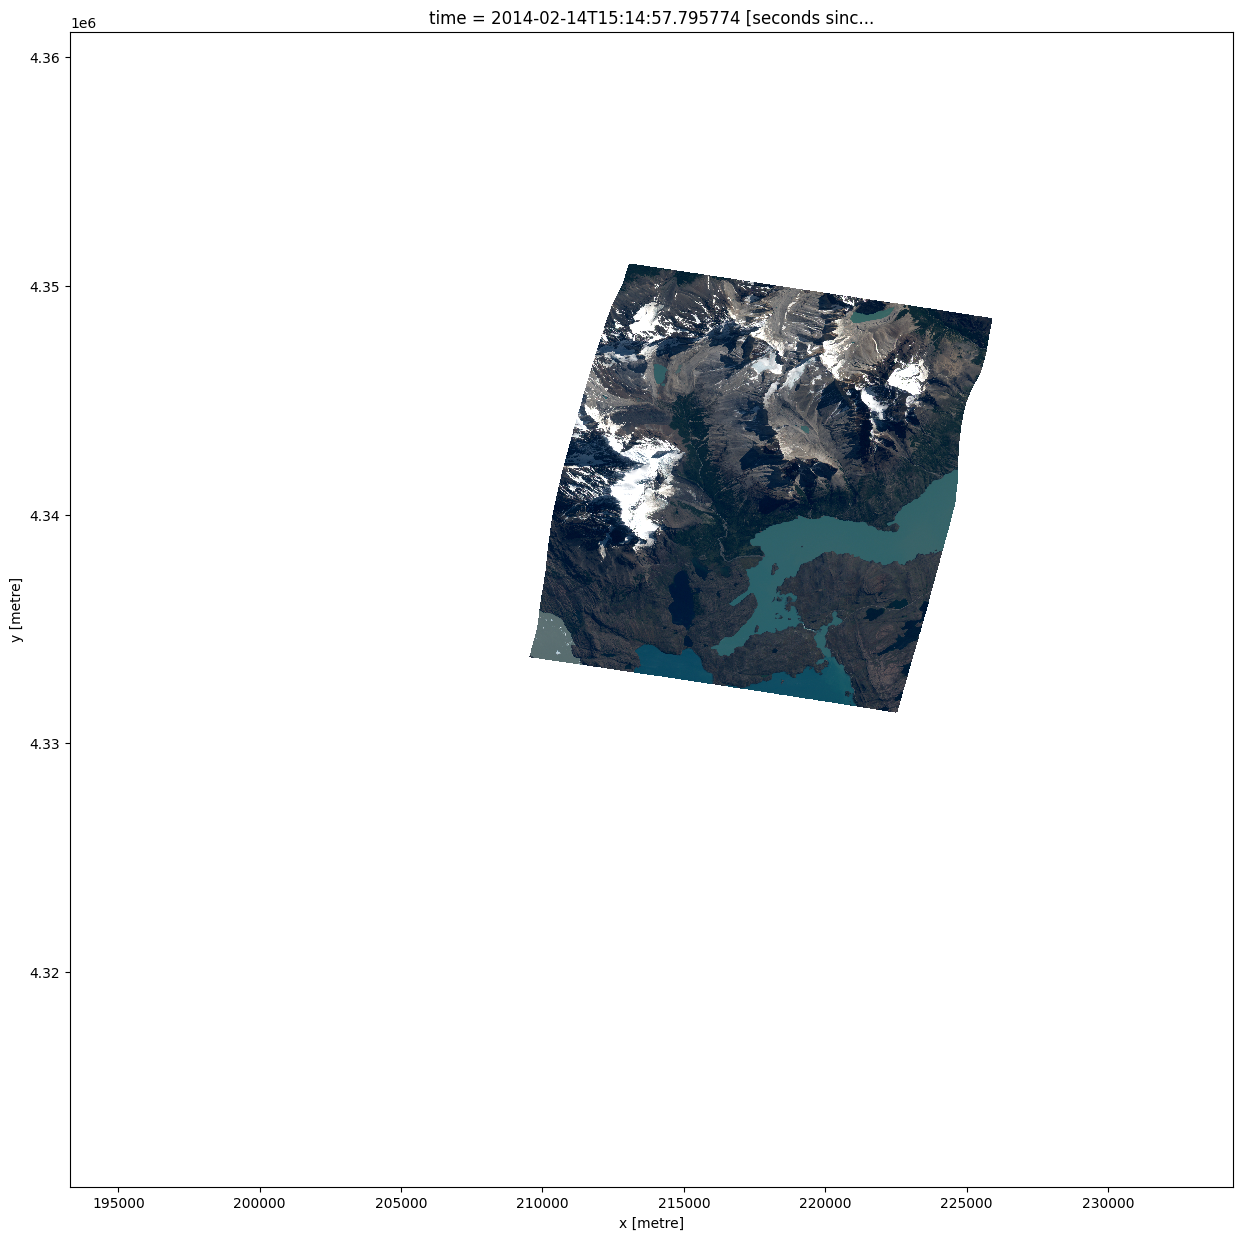

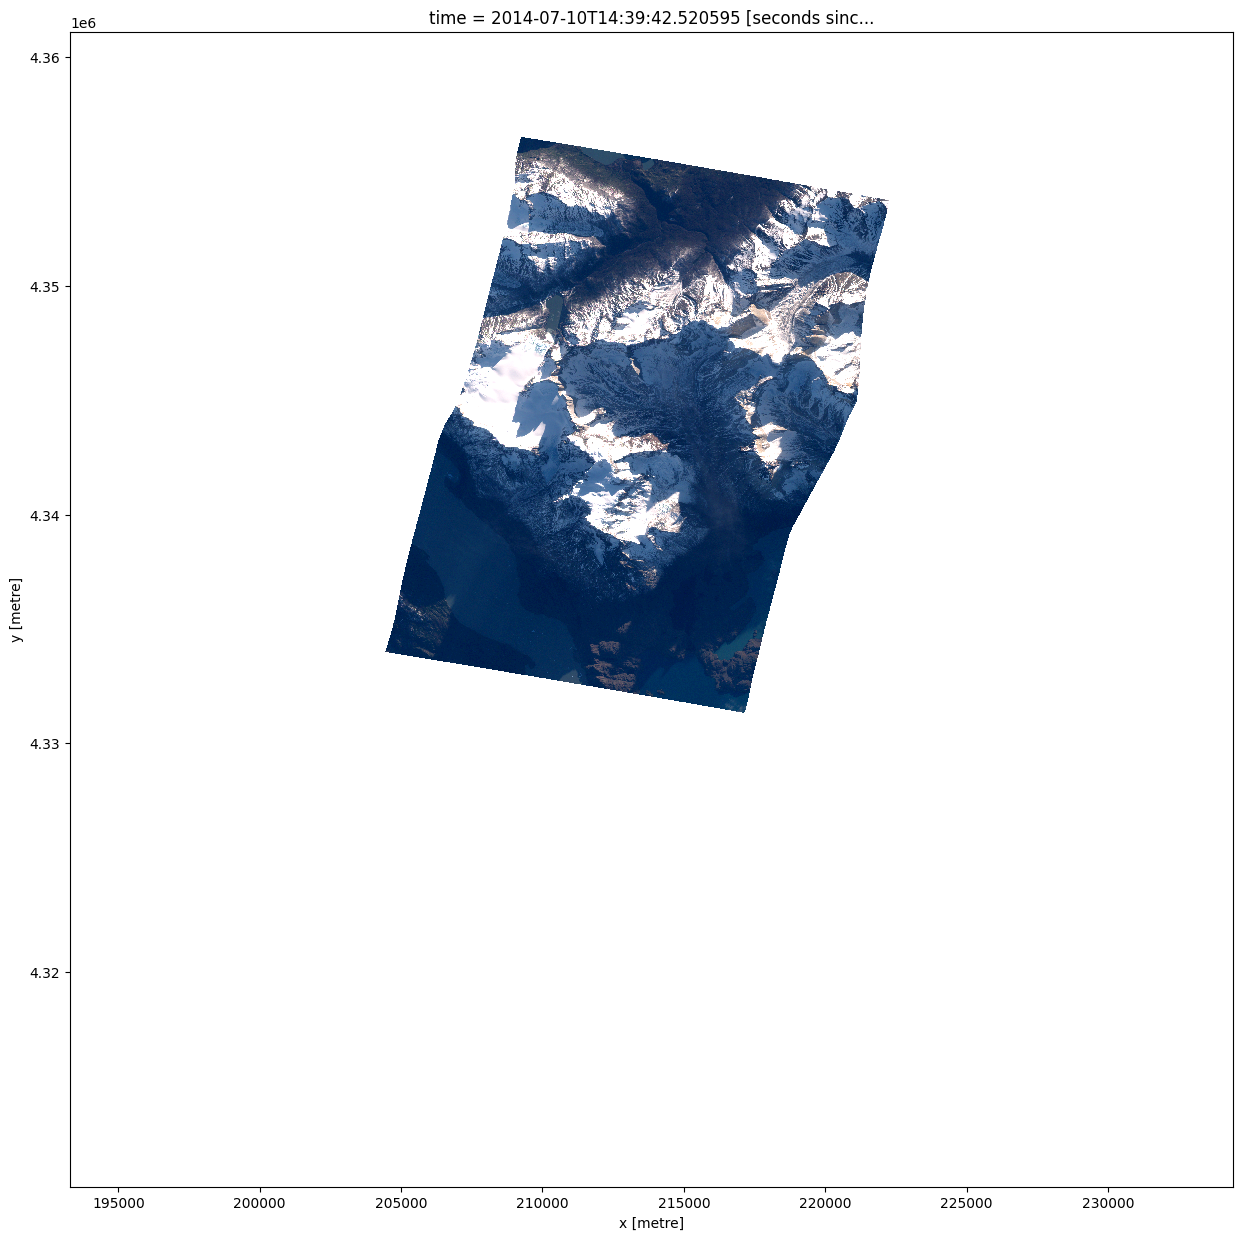

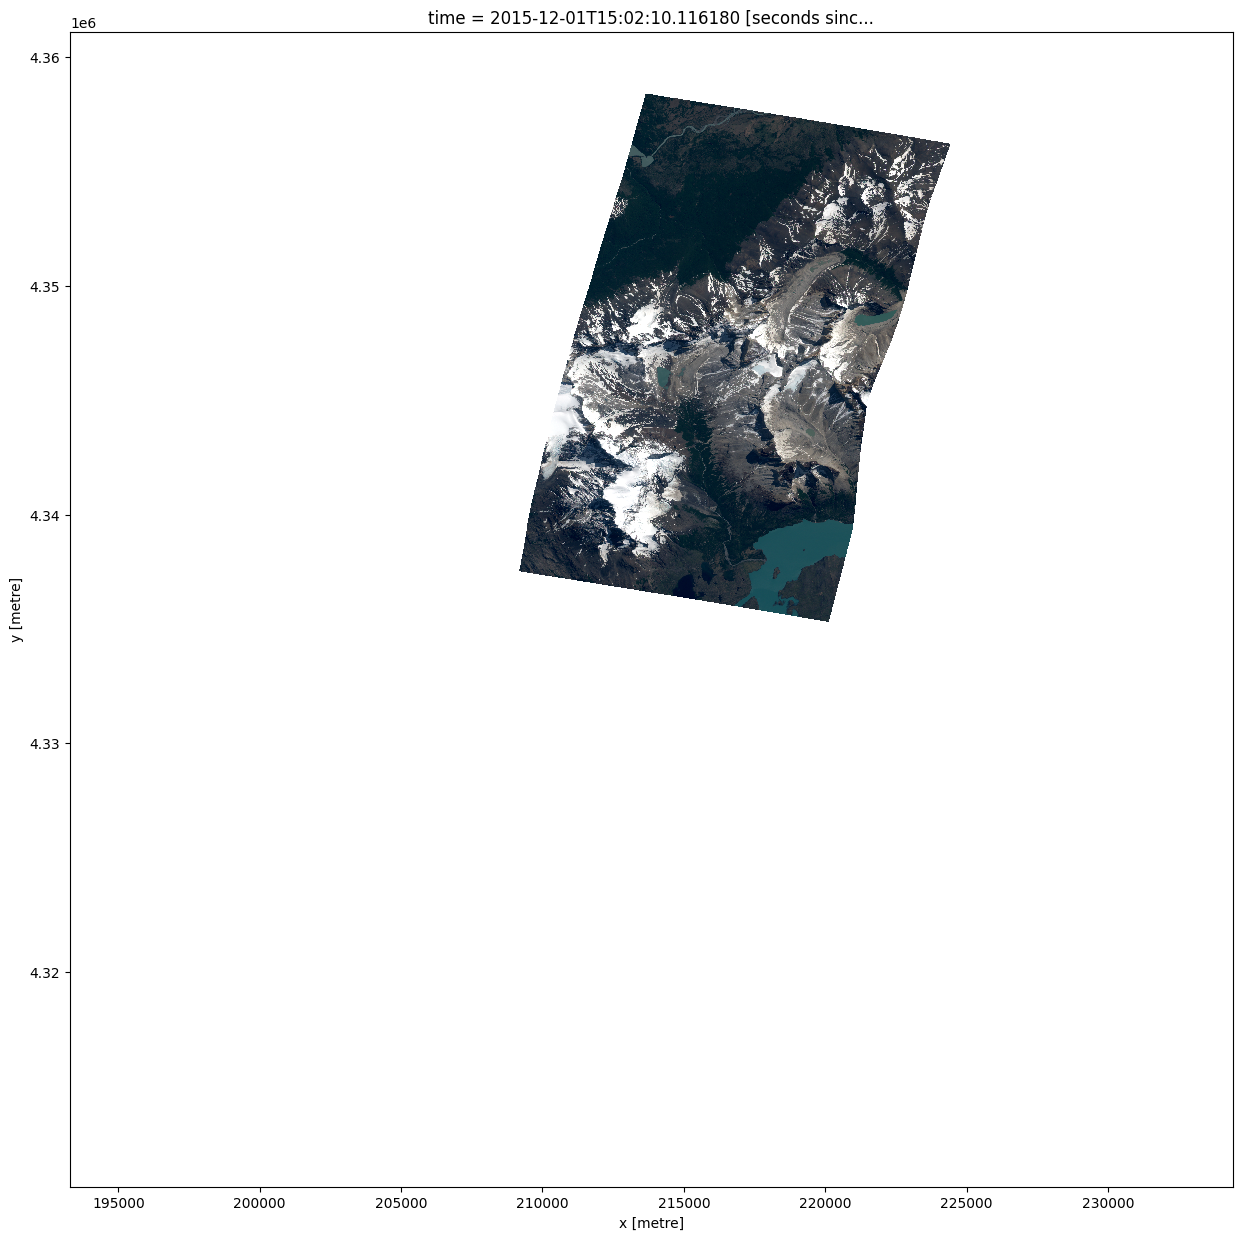

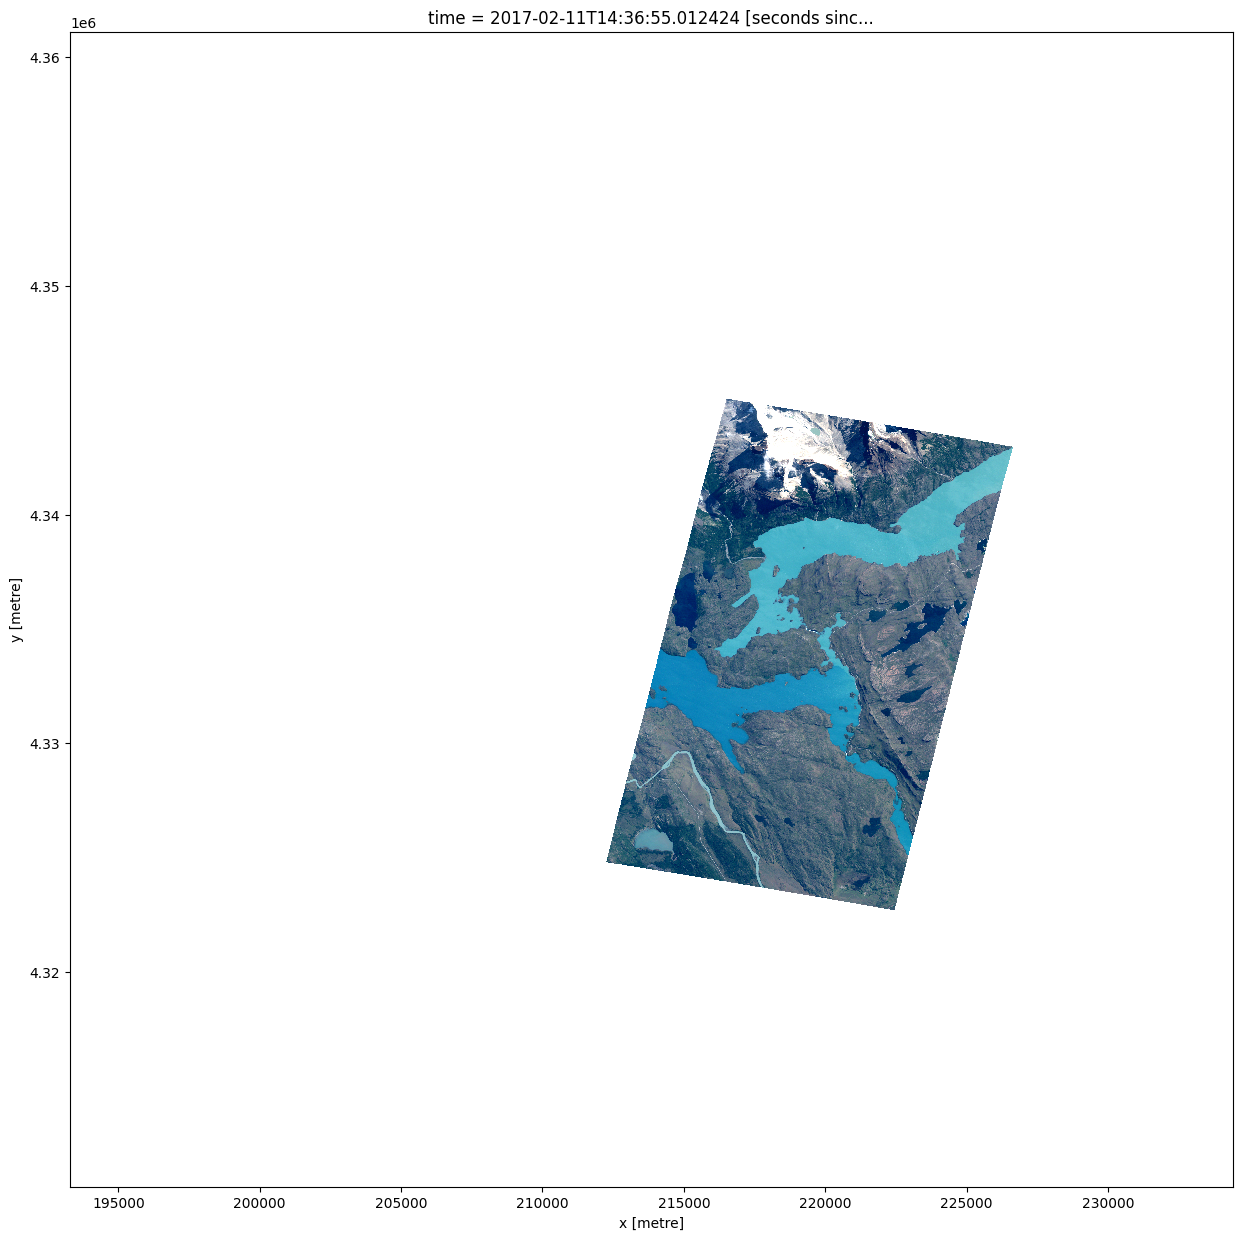

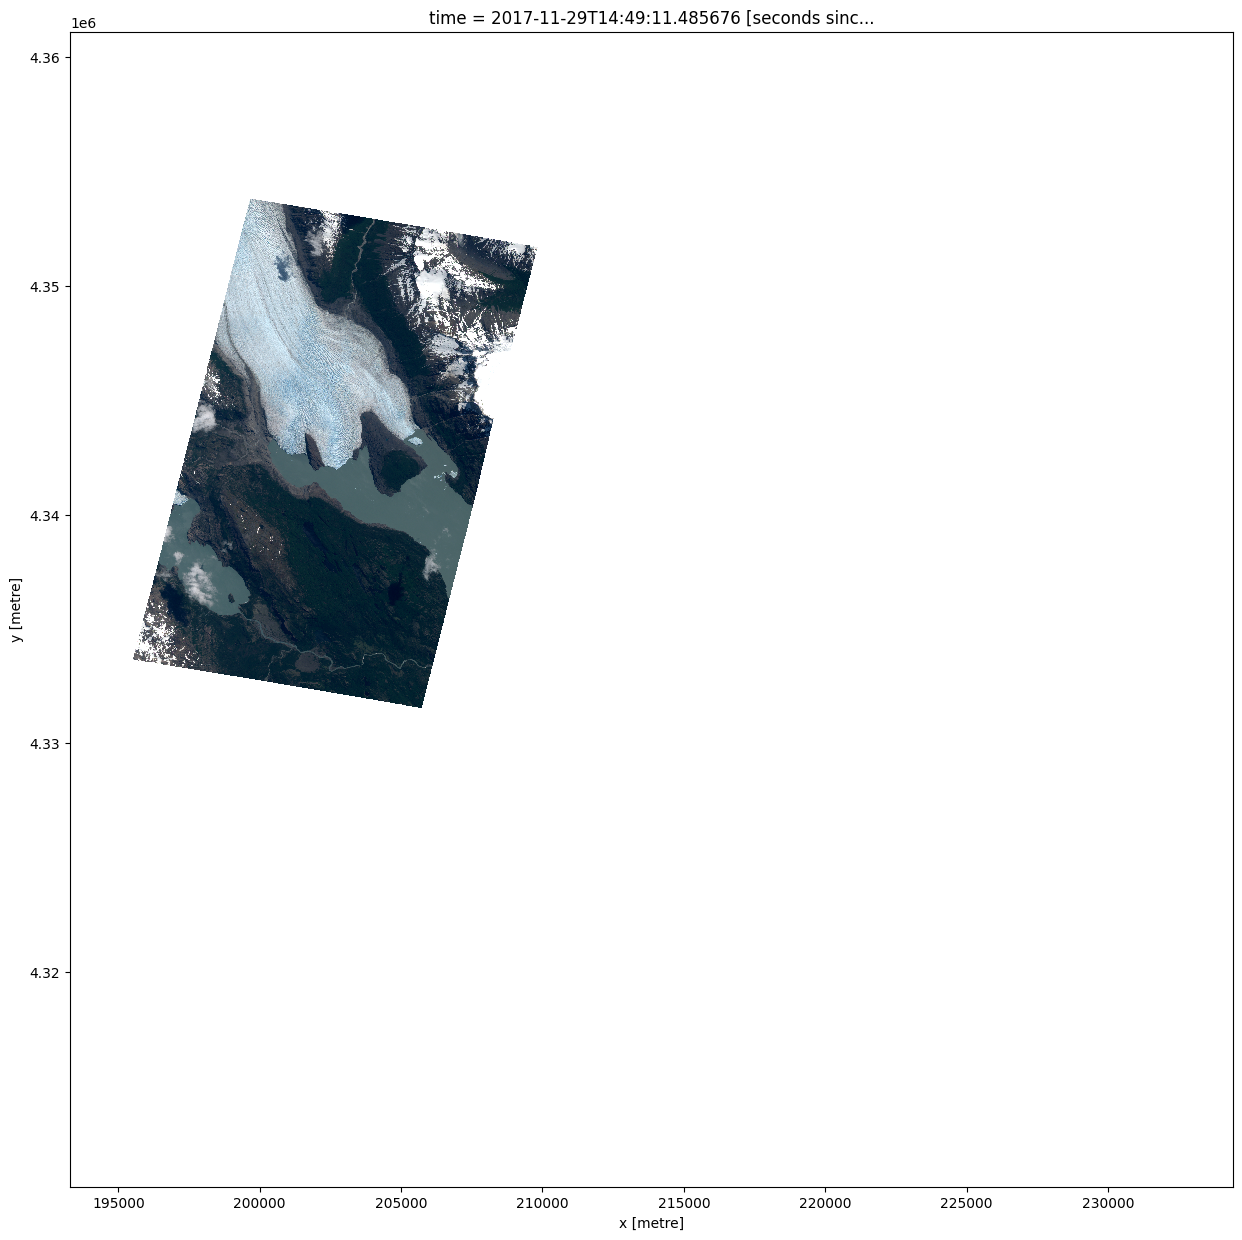

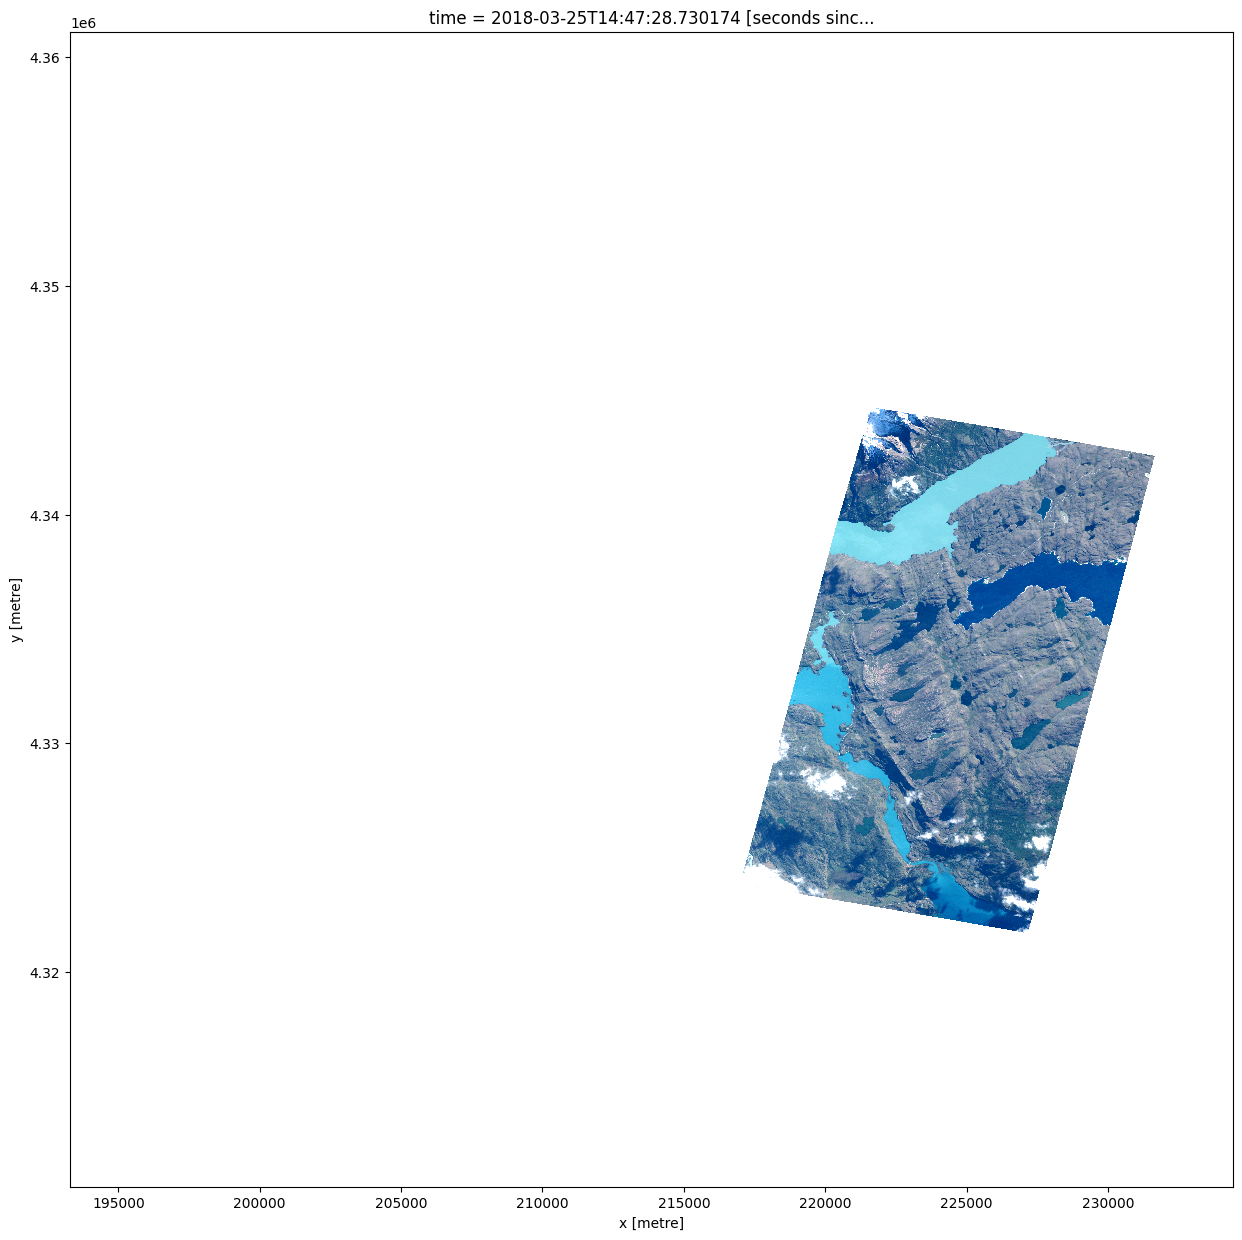

In [21]:
for i in range(8):
    #ds3.red.isel(time = i).plot(robust = True)
    np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = i)).to_array().plot.imshow(robust = True, figsize = (15,15), aspect = 1)

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


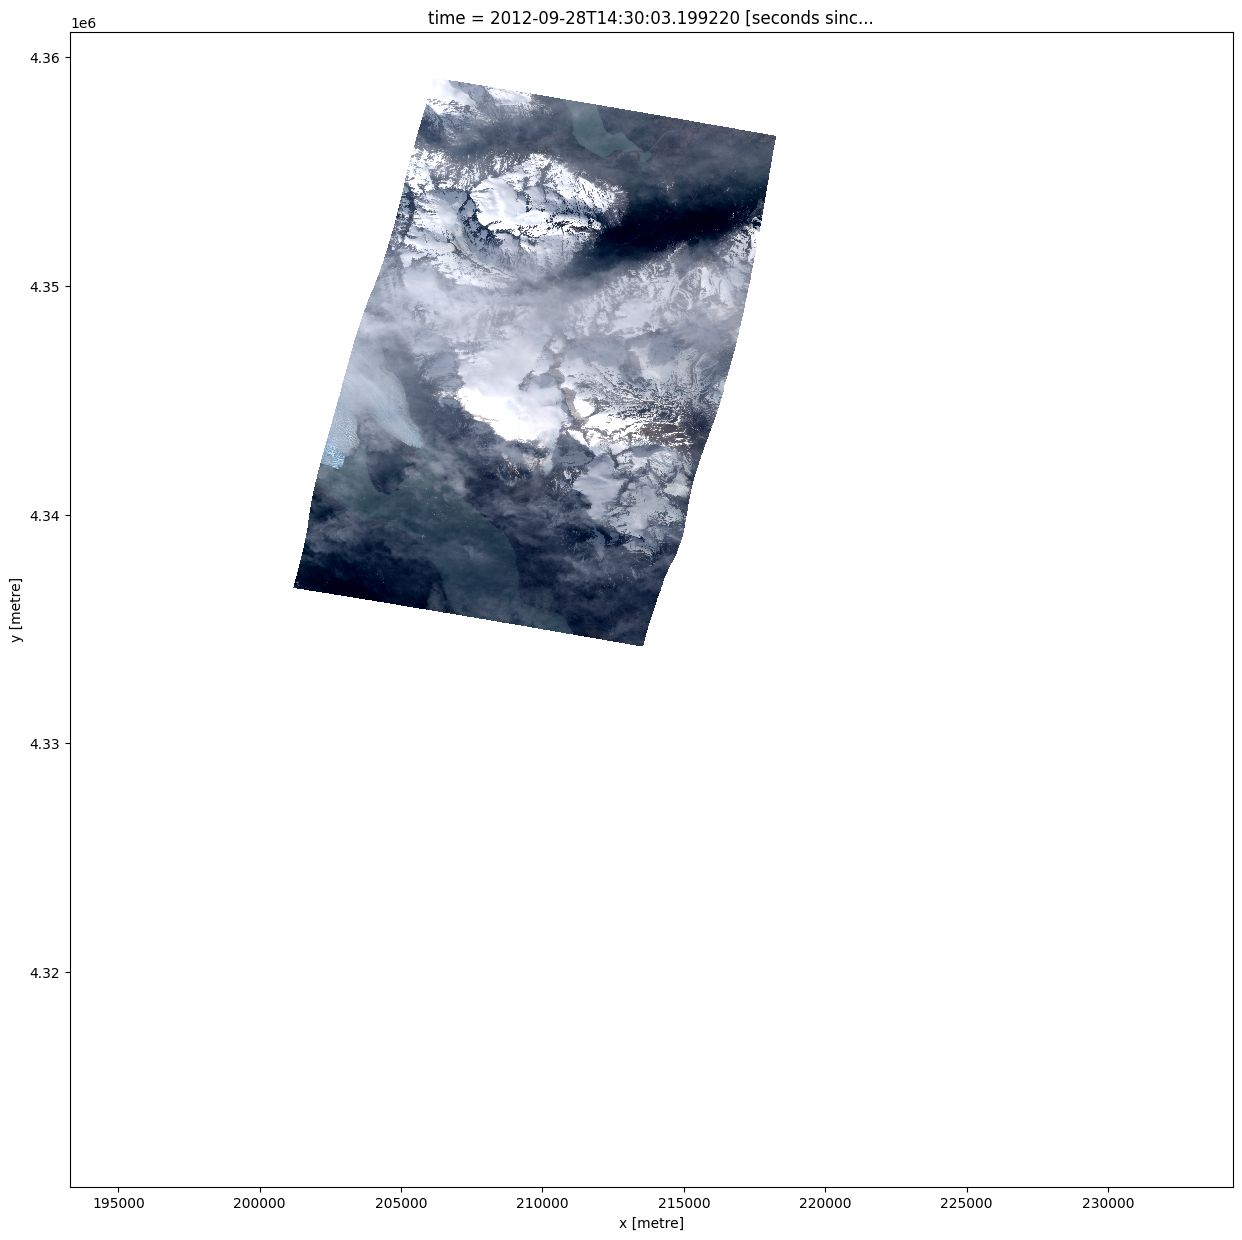

In [22]:
np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = 1)).to_array().plot.imshow(robust = True, figsize = (15,15), aspect = 1)

***

Finalmente, cerramos el cluster que hemos utilizado.

In [19]:
client.close()

cluster.close()